In [157]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore")
%matplotlib inline

# Предобработка данных

Считаем за target - SalePrice

In [158]:
from sklearn.model_selection import train_test_split
data = pd.read_csv("train.csv")
y = data["SalePrice"]
data.drop("SalePrice",axis=1,inplace=True)
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.25, random_state=42)

In [159]:
isna_data = data_train.isna().sum()
index = isna_data != 0
isna_data[index]

LotFrontage      200
Alley           1025
MasVnrType       639
MasVnrArea         4
BsmtQual          27
BsmtCond          27
BsmtExposure      27
BsmtFinType1      27
BsmtFinType2      27
Electrical         1
FireplaceQu      512
GarageType        58
GarageYrBlt       58
GarageFinish      58
GarageQual        58
GarageCond        58
PoolQC          1089
Fence            877
MiscFeature     1052
dtype: int64

Заменим NaN в колонке  LotFrontage средним по обучающей выборке значением

In [160]:
lotFrontageMean = data_train["LotFrontage"].mean()
lotFrontageMean

70.39441340782123

In [161]:
index = data_test["LotFrontage"].isna()
index.sum()

59

In [162]:
index = data_train["LotFrontage"].isna()
data_train.loc[index,"LotFrontage"] = lotFrontageMean
data_train[index]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
626,627,20,RL,70.394413,12342,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdWo,Shed,600,8,2007,WD,Normal
370,371,60,RL,70.394413,8121,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,1,2006,WD,Normal
785,786,20,RL,70.394413,9790,Pave,NaN,Reg,Lvl,AllPub,...,197,0,NaN,NaN,NaN,0,9,2009,WD,Normal
100,101,20,RL,70.394413,10603,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
1190,1191,190,RL,70.394413,32463,Pave,NaN,Reg,Low,AllPub,...,0,0,NaN,NaN,NaN,0,3,2007,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
975,976,160,FV,70.394413,2651,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Normal
856,857,80,RL,70.394413,10970,Pave,NaN,IR1,Low,AllPub,...,0,0,NaN,MnPrv,NaN,0,10,2008,WD,Normal
459,460,50,RL,70.394413,7015,Pave,NaN,IR1,Bnk,AllPub,...,0,0,NaN,NaN,NaN,0,7,2009,WD,Normal
1396,1397,20,RL,70.394413,57200,Pave,NaN,IR1,Bnk,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal


In [163]:
data_train["LotFrontage"].isna().sum()

0

NA в колонке Alley считается за No alley access, так что оставляем как одну из категорий. Аналогично для MasVnrType

Для MasVnrArea заменим на среднее

In [164]:
index = data_train["MasVnrArea"].isna()
data_train.loc[index]["MasVnrType"]

650     NaN
1278    NaN
234     NaN
977     NaN
Name: MasVnrType, dtype: object

In [165]:
index = data_test["MasVnrArea"].isna()
index.sum()


4

Заметим, что там где отсутствуют данные об площади облицовки - её нет, значит заменим 0.

In [166]:
index = data_train["MasVnrArea"].isna()
data_train.loc[index,"MasVnrArea"] = 0

С колонками про подвал NA это отсутствие подвала. Рассмотрим колонку Electrical, в которой есть 1 NA значение

In [167]:
data_train.loc[data_train["Electrical"].isna()]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1379,1380,80,RL,73.0,9735,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2008,WD,Normal


In [168]:
data_train.Electrical.value_counts()

Electrical
SBrkr    1002
FuseA      66
FuseF      23
FuseP       3
Name: count, dtype: int64

Заменим эту колонку на самую частую встречающуюся категорию - SBrkr    

In [169]:
data_train.loc[data_train["Electrical"].isna(),"Electrical"]= "SBrkr"

Рассмотрим колонки с гаражом. Прежде всего отметим сложность в GarageYrBlt, т.к. это целочисленный столбец, однако в нем есть NA, которые интерпретируются как отсутствие гаража.

# Гипотеза 1. 
Заменим все NaN в столбце GarageYrBlt на 0. Идея заключается в том, что если будет линейная регрессия, то чем новее гараж, тем больше стоимости добавляет этот фактор, поэтому вес при данном признаке будет положительным, а значит отсутствие гаража будет не изменять итоговую стоимость, что достаточно логично. В случае решение композицией или бустингом из деревьев, то это не должно повлиять на результат. 

С удалением или заменой NaN значений закончили. Теперь перейдем к обработке категориальных данных.

In [170]:
float_cols = ["LotFrontage", "LotArea","MasVnrArea","BsmtFinSF1", 
                  "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF",
                  "1stFlrSF", "2ndFlrSF", "LowQualFinSF", "GrLivArea",
                  "BsmtFullBath", "BsmtHalfBath","FullBath","HalfBath",
                   "TotRmsAbvGrd","Fireplaces", "GarageYrBlt", "GarageCars",
                  "GarageArea", "WoodDeckSF","OpenPorchSF","EnclosedPorch","3SsnPorch",
                  "ScreenPorch","PoolArea","MiscVal","MoSold","YrSold"]
cat_cols = ["MSSubClass", "MSZoning", "LotShape", "LandContour", 
                "Utilities", "LotConfig", "LandSlope", "Neighborhood",
                "Condition1", "Condition2", "BldgType", "HouseStyle",
                "OverallQual",  "OverallCond", "YearBuilt", "YearRemodAdd",
                "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd",
                "ExterQual", "ExterCond", "Foundation", "Heating", "HeatingQC",
                "CentralAir", "Electrical", "KitchenQual", "Functional","PavedDrive",
                "SaleType","SaleCondition","Street"]
def parse_data(data: pd.DataFrame) -> pd.DataFrame: 
    for col in float_cols:
        data_col = data[col]
        index =  data_col.isna()

        if data_col.dtype == "float64":
            data.loc[index, col] = data_train[col].mean()
        elif data_col.dtype == "int64" or data_col.dtype == "int32":
            cur_argmax = data_train[col].value_counts().index[0]
            data.loc[index, col] = cur_argmax
    for col in cat_cols:
        data_col = data[col]
        index =  data_col.isna()
        cur_argmax = data_train[col].value_counts().index[0]
        data.loc[index, col] = cur_argmax
    return data

In [171]:
data_train_wonan = parse_data(data_train)
data_test_wonan = parse_data(data_test)

In [172]:
data_train_wonan.shape

(1095, 80)

In [173]:
data_test_wonan.dtypes == "float64"

Id               False
MSSubClass       False
MSZoning         False
LotFrontage       True
LotArea          False
                 ...  
MiscVal          False
MoSold           False
YrSold           False
SaleType         False
SaleCondition    False
Length: 80, dtype: bool

# Анализ данных

In [174]:
import seaborn as sns

In [175]:
data_train_wonan["SalePrice"] = y_train

<AxesSubplot: xlabel='YearBuilt', ylabel='SalePrice'>

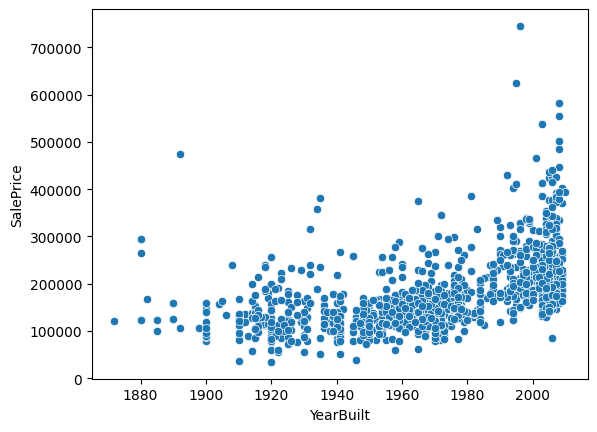

In [176]:
sns.scatterplot(data=data_train_wonan, x="YearBuilt",y="SalePrice")

<AxesSubplot: xlabel='LotFrontage', ylabel='SalePrice'>

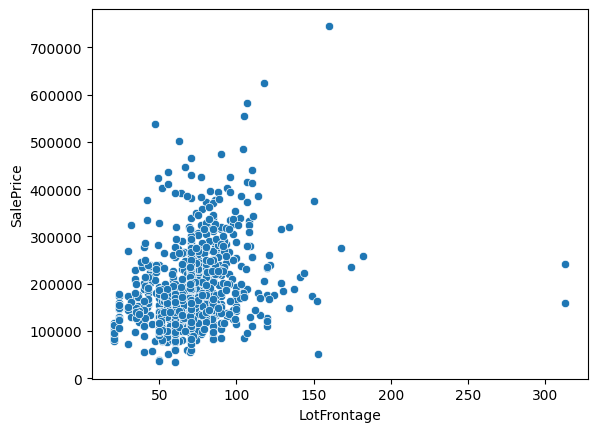

In [177]:
sns.scatterplot(data=data_train_wonan, x="LotFrontage",y="SalePrice")

<AxesSubplot: xlabel='MasVnrArea', ylabel='SalePrice'>

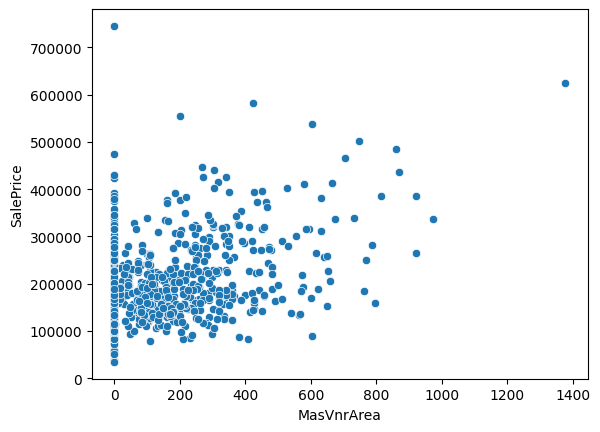

In [178]:
sns.scatterplot(data=data_train_wonan, x="MasVnrArea",y="SalePrice")

<AxesSubplot: xlabel='GarageYrBlt', ylabel='SalePrice'>

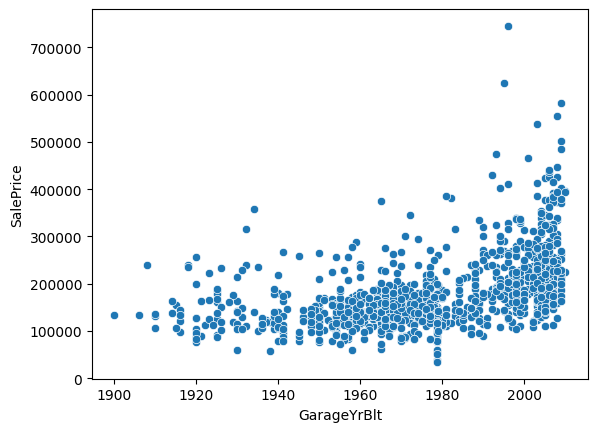

In [179]:
sns.scatterplot(data=data_train_wonan, x="GarageYrBlt",y="SalePrice")

<AxesSubplot: xlabel='YrSold', ylabel='SalePrice'>

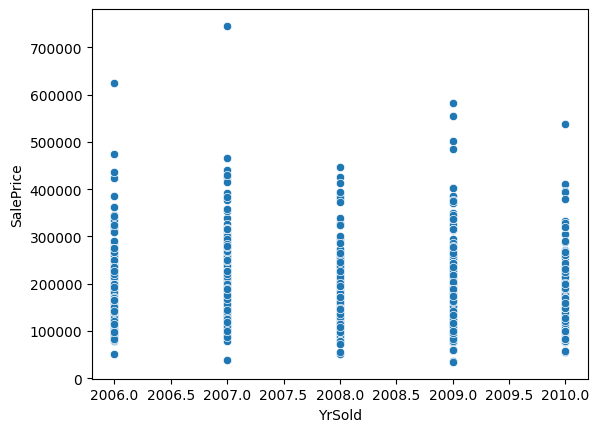

In [180]:
sns.scatterplot(data=data_train_wonan, x="YrSold",y="SalePrice")

In [181]:
numeric_cols = data_train_wonan.columns[data_train_wonan.dtypes == "float64"].to_list()
numeric_cols += data_train_wonan.columns[data_train_wonan.dtypes == "int64"].to_list()
numeric_cols += data_train_wonan.columns[data_train_wonan.dtypes == "int32"].to_list()
numeric_cols

['LotFrontage',
 'MasVnrArea',
 'GarageYrBlt',
 'Id',
 'MSSubClass',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

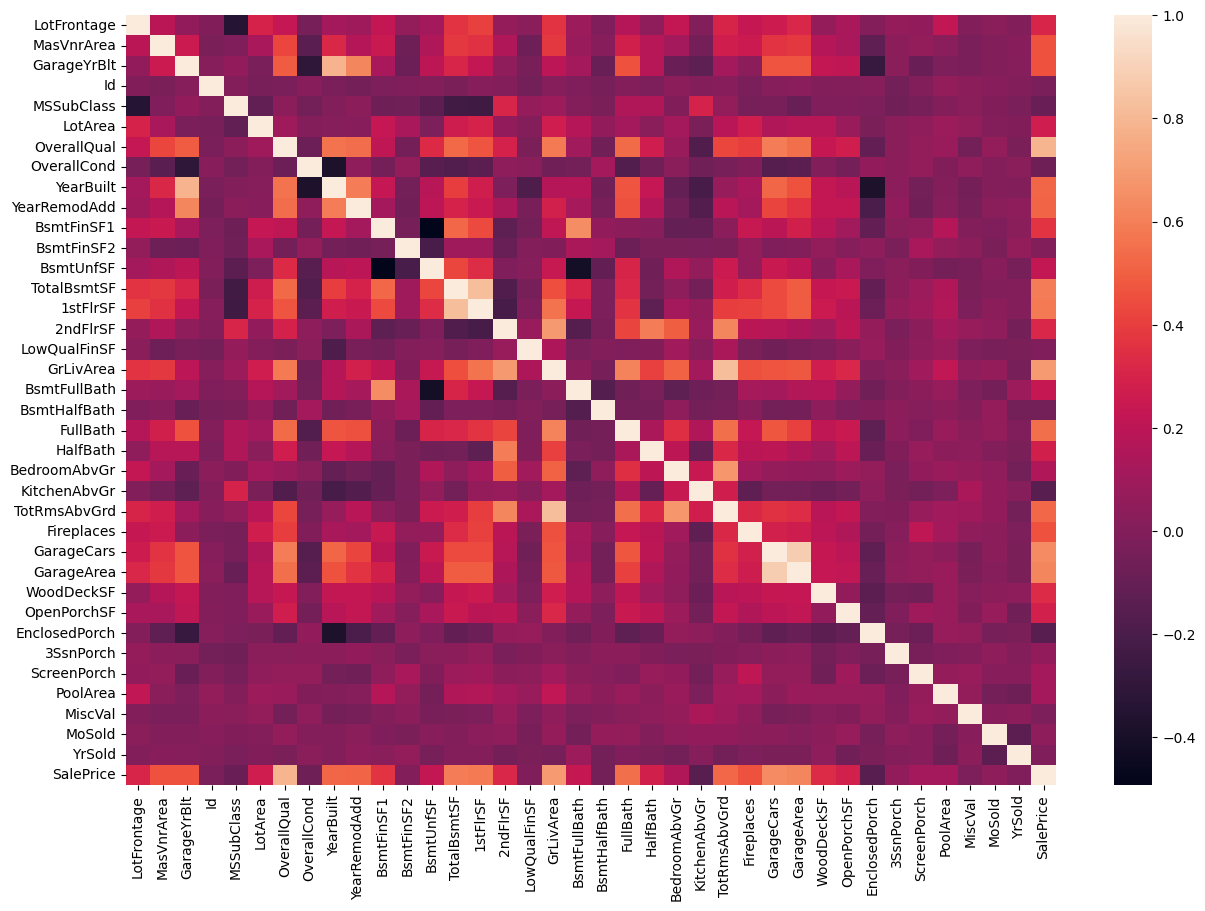

In [182]:
fig, ax = plt.subplots(figsize=(15, 10))  # Set the figure size
sns.heatmap(data_train_wonan[numeric_cols].corr(),xticklabels=True, yticklabels=True,ax=ax)
plt.show()


Рассмотрим зависимость некоррелирующих признаков от целевой переменной (возможно там более сложная зависимость, чем линейная функция)

<AxesSubplot: xlabel='MiscVal', ylabel='SalePrice'>

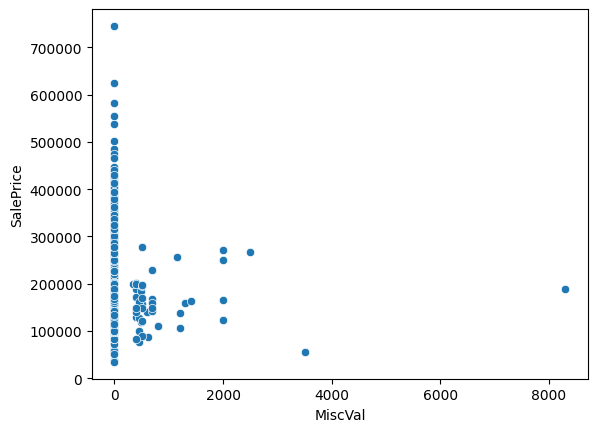

In [183]:
sns.scatterplot(data=data_train_wonan, x="MiscVal", y = "SalePrice")

<AxesSubplot: xlabel='MiscVal'>

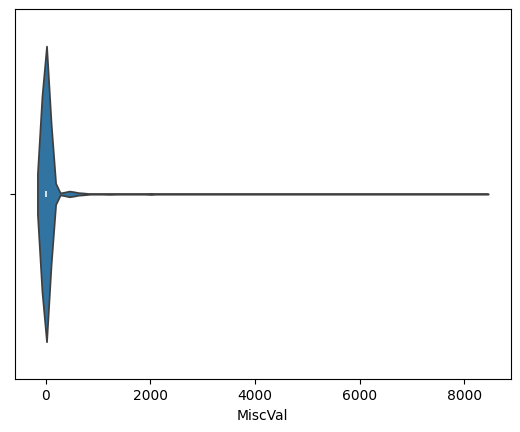

In [184]:
sns.violinplot(data=data_train_wonan, x="MiscVal")

<AxesSubplot: xlabel='YrSold', ylabel='SalePrice'>

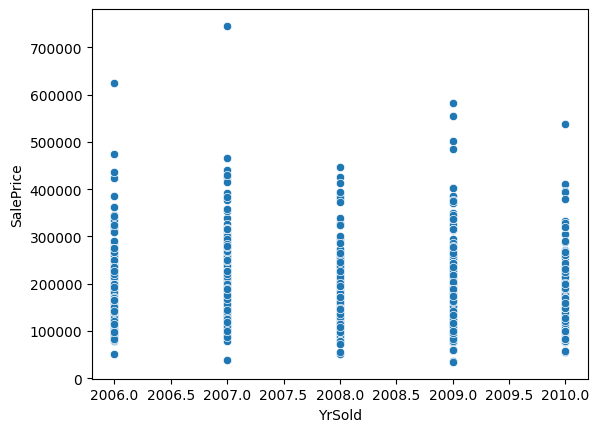

In [185]:
sns.scatterplot(data=data_train_wonan, x="YrSold", y = "SalePrice")

<AxesSubplot: xlabel='3SsnPorch'>

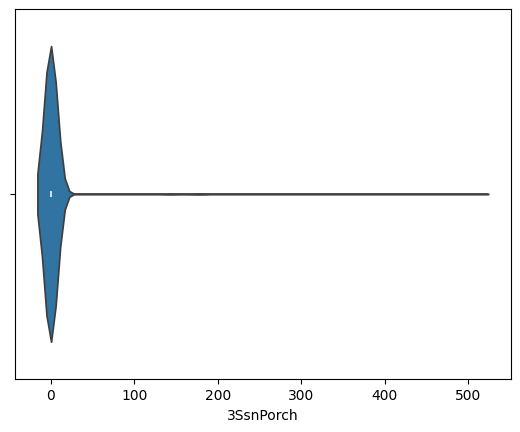

In [186]:
sns.violinplot(data=data_train_wonan, x="3SsnPorch")

<AxesSubplot: xlabel='MoSold', ylabel='SalePrice'>

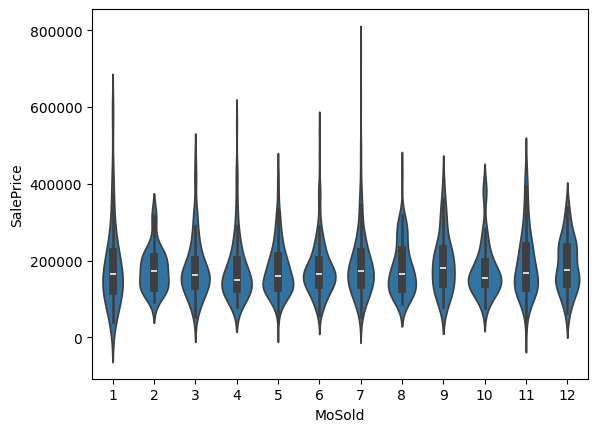

In [187]:
sns.violinplot(data=data_train_wonan, x="MoSold", y ="SalePrice")

<AxesSubplot: xlabel='BsmtHalfBath', ylabel='SalePrice'>

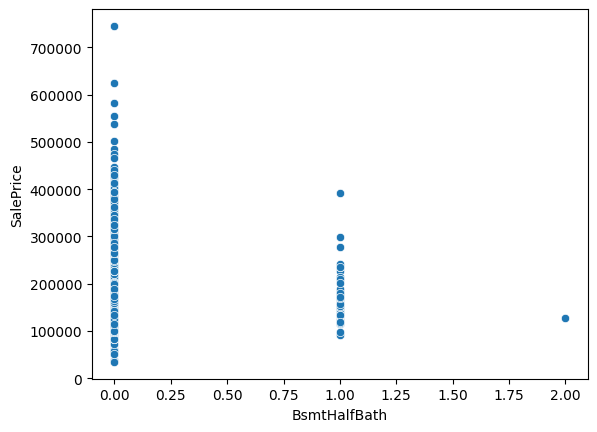

In [188]:
sns.scatterplot(data=data_train_wonan, x = "BsmtHalfBath", y = "SalePrice")

Организуем это в виде функции

In [189]:
def delete_cols(data: pd.DataFrame) -> pd.DataFrame:
    cols = ["TotalBsmtSF", "GarageCars", "TotRmsAbvGrd", 
            "MiscVal", "YrSold", "3SsnPorch", "MoSold",
            "BsmtHalfBath"]
    return data.drop(axis=1, columns=cols)

In [190]:
data_test_wonan = delete_cols(data_test_wonan)
data_train_wonan = delete_cols(data_train_wonan)

# Обработка категориальных данных

In [191]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 1023 to 1126
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1095 non-null   int64  
 1   MSSubClass     1095 non-null   int64  
 2   MSZoning       1095 non-null   object 
 3   LotFrontage    1095 non-null   float64
 4   LotArea        1095 non-null   int64  
 5   Street         1095 non-null   object 
 6   Alley          70 non-null     object 
 7   LotShape       1095 non-null   object 
 8   LandContour    1095 non-null   object 
 9   Utilities      1095 non-null   object 
 10  LotConfig      1095 non-null   object 
 11  LandSlope      1095 non-null   object 
 12  Neighborhood   1095 non-null   object 
 13  Condition1     1095 non-null   object 
 14  Condition2     1095 non-null   object 
 15  BldgType       1095 non-null   object 
 16  HouseStyle     1095 non-null   object 
 17  OverallQual    1095 non-null   int64  
 18  OverallCon

Имеем 43 категориальных признака. Отметим те признаки, в которых есть зависимость порядка. Их будем кодироваться Label Encoder'ом, остальные через One-Hot Encoder

К категориальным признакам с порядком относятся: LotShape, LandContour, Utilities, LandSlope, ExterQual, ExterCond, BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2, HeatingQC, CentralAir, Electrical, KitchenQual, FireplaceQu, GarageFinish, GarageQual, GarageCond, PavedDrive, PoolQC.

In [192]:
from sklearn.preprocessing import LabelEncoder

def encode_data(data: pd.DataFrame) -> pd.DataFrame:
    #Label encoding упорядоченных признаков
    col_value = {"LotShape": ["Reg", "IR1", "IR2", "IR3"],
                 "LandContour": ["Lvl", "Bnk", "HLS", "Low"],
                 "Utilities": ["AllPub", "NoSewr", "NoSeWa", "ELO"],
                 "LandSlope": ["Gtl", "Mod", "Sev"],
                 "ExterQual" : ["Ex", "Gd", "TA", "Fa", "Po"],
                 "ExterCond": ["Ex", "Gd", "TA", "Fa", "Po"],
                 "BsmtQual": ["Ex", "Gd", "TA", "Fa", "Po", "nan"],
                 "BsmtCond": ["Ex", "Gd", "TA", "Fa", "Po", "nan"],
                 "BsmtExposure": ["Gd", "Av", "Mn", "No", "nan"],
                 "BsmtFinType1": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf","nan"],
                 "BsmtFinType2": ["GLQ", "ALQ", "BLQ", "Rec", "LwQ", "Unf","nan"],
                 "HeatingQC": ["Ex", "Gd", "TA", "Fa", "Po"],
                 "CentralAir": ["N", "Y"],
                 "Electrical": ["SBrkr", "FuseA", "FuseF", "FuseP", "Mix"],
                 "KitchenQual": ["Ex", "Gd", "TA", "Fa", "Po"],
                 "FireplaceQu": ["Ex", "Gd", "TA", "Fa", "Po", "nan"],
                 "GarageFinish": ["Fin", "RFn", "Unf","nan"],
                 "GarageQual": ["Ex", "Gd", "TA", "Fa", "Po", "nan"],
                 "GarageCond": ["Ex", "Gd", "TA", "Fa", "Po", "nan"],
                 "PavedDrive": ["Y", "P", "N"],
                 "PoolQC": ["Ex", "Gd", "TA", "Fa", "nan"]
                 }
    for col in col_value:
        le = LabelEncoder()
        le.fit(col_value[col])
        data[col] = le.transform(data[col])
    

    # One-hot кодирование остальных
    cols = ['MSZoning', 'Street', 'Alley', 'LotConfig', 'Neighborhood',
        'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle',
        'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
        'Heating', 'Functional', 'GarageType', 'Fence', 'MiscFeature',
        'SaleType', 'SaleCondition']
    data = pd.get_dummies(data, columns = cols, drop_first=True, dummy_na=True)
    return data

In [193]:
data_train_enc = encode_data(data_train_wonan)
data_test_enc = encode_data(data_test_wonan)

In [194]:
data_test_wonan.columns[(data_test_wonan.isna().sum() > 0)]

Index(['Alley', 'MasVnrType', 'GarageType', 'Fence', 'MiscFeature'], dtype='object')

In [195]:
data_test_enc

,Id,MSSubClass,LotFrontage,LotArea,LotShape,LandContour,Utilities,LandSlope,OverallQual,OverallCond,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleCondition_nan
892,893,20,70.000000,8414,3,3,0,0,6,8,...,False,False,False,True,False,False,False,True,False,False
1105,1106,60,98.000000,12256,0,3,0,0,8,5,...,False,False,False,True,False,False,False,True,False,False
413,414,30,56.000000,8960,3,3,0,0,5,6,...,False,False,False,True,False,False,False,True,False,False
522,523,50,50.000000,5000,3,3,0,0,6,7,...,False,False,False,True,False,False,False,True,False,False
1036,1037,20,89.000000,12898,0,1,0,0,9,5,...,False,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
988,989,60,70.394413,12046,0,3,0,0,6,6,...,False,False,False,True,False,False,False,True,False,False
243,244,160,75.000000,10762,3,3,0,0,6,6,...,False,False,False,True,False,False,False,True,False,False
1342,1343,60,70.394413,9375,3,3,0,0,8,5,...,False,False,False,True,False,False,False,True,False,False
1057,1058,60,70.394413,29959,1,3,0,0,7,6,...,False,False,False,True,False,False,False,True,False,False


In [196]:
print(data_test_enc.columns.values)

['Id' 'MSSubClass' 'LotFrontage' 'LotArea' 'LotShape' 'LandContour'
 'Utilities' 'LandSlope' 'OverallQual' 'OverallCond' 'YearBuilt'
 'YearRemodAdd' 'MasVnrArea' 'ExterQual' 'ExterCond' 'BsmtQual' 'BsmtCond'
 'BsmtExposure' 'BsmtFinType1' 'BsmtFinSF1' 'BsmtFinType2' 'BsmtFinSF2'
 'BsmtUnfSF' 'HeatingQC' 'CentralAir' 'Electrical' '1stFlrSF' '2ndFlrSF'
 'LowQualFinSF' 'GrLivArea' 'BsmtFullBath' 'FullBath' 'HalfBath'
 'BedroomAbvGr' 'KitchenAbvGr' 'KitchenQual' 'Fireplaces' 'FireplaceQu'
 'GarageYrBlt' 'GarageFinish' 'GarageArea' 'GarageQual' 'GarageCond'
 'PavedDrive' 'WoodDeckSF' 'OpenPorchSF' 'EnclosedPorch' 'ScreenPorch'
 'PoolArea' 'PoolQC' 'MSZoning_FV' 'MSZoning_RH' 'MSZoning_RL'
 'MSZoning_RM' 'MSZoning_nan' 'Street_Pave' 'Street_nan' 'Alley_Pave'
 'Alley_nan' 'LotConfig_CulDSac' 'LotConfig_FR2' 'LotConfig_FR3'
 'LotConfig_Inside' 'LotConfig_nan' 'Neighborhood_Blueste'
 'Neighborhood_BrDale' 'Neighborhood_BrkSide' 'Neighborhood_ClearCr'
 'Neighborhood_CollgCr' 'Neighborhood_Crawfo

In [197]:
data_test_enc = data_test_enc.fillna(0)

In [198]:
data_test_enc[data_test_enc["Id"] == 893]["Condition1_PosA"]

892    False
Name: Condition1_PosA, dtype: bool

In [199]:
data_train_enc.drop(axis=1, columns = ["SalePrice"], inplace = True)

In [200]:
(data_test_enc.shape == data_train_enc.shape)

False

In [201]:
left = data_test_enc.align(data_train_enc, join='right', axis=1, fill_value=0)[0]
data_test_enc = left

# Построение моделей

In [202]:
data_test_enc.isna().sum().sum()

0

In [203]:
X_train = data_train_enc
X_test = data_test_enc

### Линейная регрессия

Отфильтруем незначащие признаки с помощью L1. Заодно проверим качество на линейной модели

In [204]:
X_train_scaled = X_train
X_test_scaled =  X_test

In [205]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test_scaled =  pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [206]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

Будем отбирать такое альфа, которое на среднем арифметическом для кросс-валидации дает лучший результат

In [207]:
alphas = np.linspace(30,500,num=25)
mean_score = []


for alpha in alphas:
    reg = Lasso(alpha)
    mean_score += [cross_val_score(reg, X_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()]

Text(0.5, 1.0, 'negRMSE')

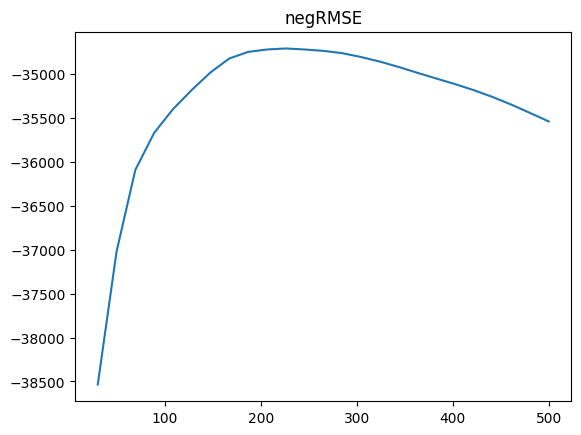

In [208]:
plt.plot(alphas,mean_score)
plt.title("negRMSE")

In [209]:
max(mean_score)

-34709.4983989691

In [210]:

best_alpha = alphas[np.argmax(mean_score)]
best_alpha

225.83333333333331

Уточним данные

Text(0.5, 1.0, 'negRMSE')

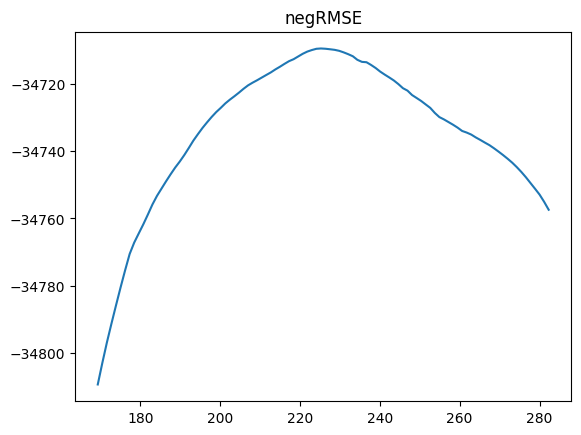

In [211]:
alphas = np.linspace(max(0, 0.75*best_alpha),1.25*best_alpha,num=100)
mean_score = []


for alpha in alphas:
    reg = Lasso(alpha)
    mean_score += [cross_val_score(reg, X_train_scaled, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()]

plt.plot(alphas,mean_score)
plt.title("negRMSE")

In [212]:
best_alpha = alphas[np.argmax(mean_score)]
best_alpha

225.2630471380471

Создаем модель и отбираем признаки, которые надо удалить (значение параметра меньше 1e-2)

In [213]:
best_lin_reg = Lasso(best_alpha)
best_lin_reg.fit(X_train_scaled, y_train)

Lasso(alpha=225.2630471380471)

In [214]:
best_lin_reg.score(X_test_scaled, y_test)

0.8515526256976567

In [215]:
abs(best_lin_reg.coef_) < 1e-2

array([False, False,  True,  True, False, False,  True, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False,  True,  True,  True,  True,  True, False,  True,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False, False,  True, False, False,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True, False,  True,  True, False, False, False,
        True,  True,  True, False, False,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True, False, False,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,

In [216]:
del_cols = X_train_scaled.columns[abs(best_lin_reg.coef_) < 1e-2]
len(del_cols)

153

In [217]:
X_train_wo_cols = X_train_scaled.drop(axis=1, columns = del_cols)
X_test_wo_cols = X_test_scaled.drop(axis=1, columns = del_cols)

In [218]:
best_lin_reg = Lasso(best_alpha)
best_lin_reg.fit(X_train_wo_cols, y_train)

Lasso(alpha=225.2630471380471)

In [219]:
X_test_wo_cols.isna().sum().sum()

0

In [220]:
best_lin_reg.score(X_train_wo_cols, y_train)

0.8536124092498696

In [221]:
best_lin_reg.score(X_test_wo_cols, y_test)

0.8515487023087932

In [222]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import root_mean_squared_error

y_pred = best_lin_reg.predict(X_test_wo_cols)
root_mean_squared_error(y_test, y_pred)

32248.212656637734

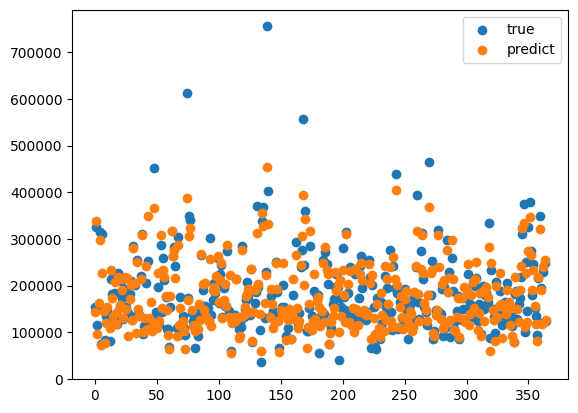

In [223]:
plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(y_pred)), y_pred)
plt.legend(["true","predict"])

In [224]:
y_pred = best_lin_reg.predict(X_train_wo_cols)
root_mean_squared_error(y_train, y_pred)

29812.484382325845

Ошибаемся в среднем на 10%

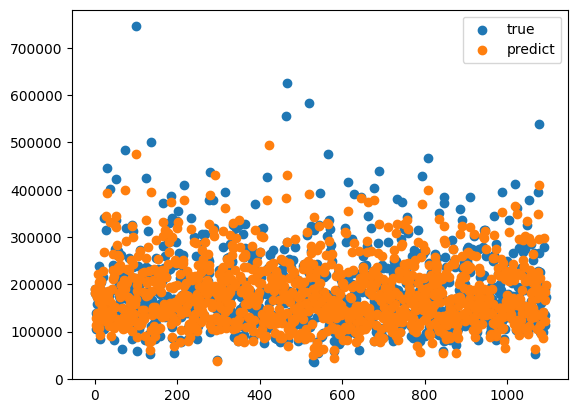

In [225]:
plt.scatter(range(len(y_train)), y_train)
plt.scatter(range(len(y_train)), y_pred)
plt.legend(["true","predict"])

Теперь попробуем воспользоваться другими методами

### Случайный лес

In [226]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=200, criterion="squared_error", random_state=42, n_jobs=2)

In [227]:
rf_reg.fit(X_train_wo_cols, y_train)

RandomForestRegressor(n_estimators=200, n_jobs=2, random_state=42)

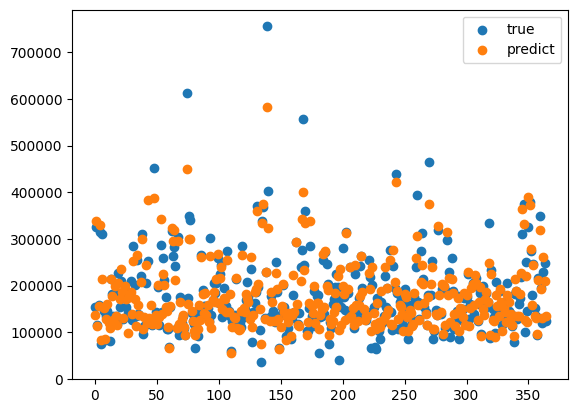

In [228]:
y_pred_rf = rf_reg.predict(X_test_wo_cols)

plt.scatter(range(len(y_test)), y_test)
plt.scatter(range(len(y_pred_rf)), y_pred_rf)
plt.legend(["true","predict"])

In [229]:
root_mean_squared_error(y_pred_rf, y_test)

28892.37552140033

In [230]:
y_pred_train_rf = rf_reg.predict(X_train_wo_cols)
root_mean_squared_error(y_pred_train_rf, y_train)

11624.336469107524

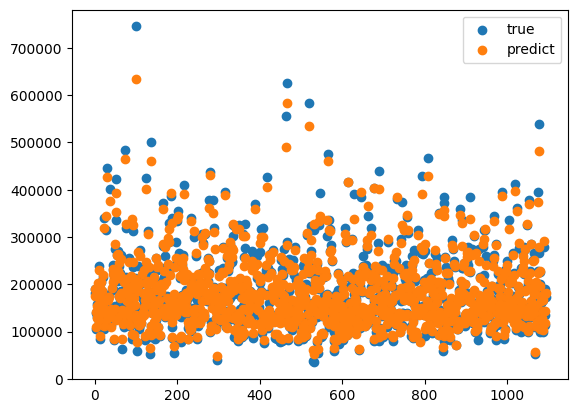

In [231]:
plt.scatter(range(len(y_train)), y_train)
plt.scatter(range(len(y_pred_train_rf)), y_pred_train_rf)
plt.legend(["true","predict"])

Снизили MAE на 2000 для тестовой выборки и в 2 раза для тренировочной.

### Градиентный бустинг

In [232]:
from catboost import CatBoostRegressor

In [233]:
cur_depth = 5
cur_lr = 0.01
model = CatBoostRegressor(iterations=1000, depth= cur_depth, learning_rate=cur_lr, loss_function="RMSE")

In [234]:
depths = range(3,7)
lrs = np.linspace(0.1,0.15,10)
mean_score = []
iter = 0

for depth in depths:
    for lr in lrs:
        iter += 1
        model = CatBoostRegressor(iterations=1000, depth= depth, learning_rate=lr, loss_function="RMSE",logging_level="Silent")
        mean_score += [[cross_val_score(model, X_train_wo_cols, y_train, cv=5, scoring="neg_mean_squared_error").mean(), depth, lr]];
        print(iter / (len(depths)*len(lrs)) * 100)

2.5
5.0
7.5
10.0
12.5
15.0
17.5
20.0
22.5
25.0
27.500000000000004
30.0
32.5
35.0
37.5
40.0
42.5
45.0
47.5
50.0
52.5
55.00000000000001
57.49999999999999
60.0
62.5
65.0
67.5
70.0
72.5
75.0
77.5
80.0
82.5
85.0


KeyboardInterrupt: 

In [90]:
mean_score.__len__()

30

In [100]:
maxx = max(mean_score,key=lambda x: x[0])
best_depth = maxx[1]
best_lr = maxx[2]
maxx

[-808297076.8930237, 5, 0.14444444444444443]

Получили depth = 5, lr = 0.14

In [101]:
model = CatBoostRegressor(iterations=500, depth= best_depth, learning_rate=best_lr, loss_function="RMSE")

In [ ]:
model.fit(X_train_wo_cols, y_train)

0:	learn: 71403.5640947	total: 1.45ms	remaining: 723ms
1:	learn: 65443.7517203	total: 2.77ms	remaining: 691ms
2:	learn: 60561.2302592	total: 3.85ms	remaining: 638ms
3:	learn: 56147.6274199	total: 4.8ms	remaining: 595ms
4:	learn: 52756.1764299	total: 5.99ms	remaining: 593ms
5:	learn: 49196.5023424	total: 7.36ms	remaining: 606ms
6:	learn: 46311.4246450	total: 8.51ms	remaining: 599ms
7:	learn: 44030.6458711	total: 9.62ms	remaining: 592ms
8:	learn: 41954.3511640	total: 10.7ms	remaining: 586ms
9:	learn: 40314.0424920	total: 11.7ms	remaining: 572ms
10:	learn: 38708.6597517	total: 12.7ms	remaining: 563ms
11:	learn: 37423.4170673	total: 13.6ms	remaining: 555ms
12:	learn: 36327.3283629	total: 14.6ms	remaining: 545ms
13:	learn: 35106.4436377	total: 15.7ms	remaining: 546ms
14:	learn: 34167.0220722	total: 17ms	remaining: 549ms
15:	learn: 33104.4583238	total: 18ms	remaining: 544ms
16:	learn: 32300.4257926	total: 19ms	remaining: 539ms
17:	learn: 31562.3330228	total: 19.9ms	remaining: 533ms
18:	learn

In [103]:
y_pred_gd = model.predict(X_test_wo_cols)

In [104]:
root_mean_squared_error(y_pred_gd,y_test)

26762.632110630926

In [105]:
y_pred_gd_train = model.predict(X_train_wo_cols)
root_mean_squared_error(y_pred_gd_train,y_train)

5017.877935375604

Получили модель, которая выдает результаты лучше, чем RF и линейная регрессия

In [114]:
kaggle_data = pd.read_csv("test.csv")

In [117]:
kaggle_data.shape

(1459, 80)

In [115]:
kaggle_data_parsed = encode_data(delete_cols(parse_data(kaggle_data)))

In [125]:
left = kaggle_data_parsed.align(data_train_enc, join='right', axis=1, fill_value=0)[0]
kaggle_data_parsed = left

In [126]:
kaggle_data_parsed.shape

(1459, 212)

In [123]:
X_test.shape

(365, 212)

In [ ]:
kaggle_data_parsed  =  pd.DataFrame(scaler.transform(kaggle_data_parsed), columns=kaggle_data_parsed.columns)

In [ ]:
kaggle_data_parsed.drop(axis=1, columns = del_cols, inplace=True)

In [129]:
y_kaggle = model.predict(kaggle_data_parsed)

In [130]:
y_kaggle

array([128750.30502723, 149481.97583809, 187531.49550429, ...,
       162968.50868528, 108865.65523969, 223394.78966918])

In [145]:
ids = kaggle_data["Id"].values

In [147]:
ids

array([1461, 1462, 1463, ..., 2917, 2918, 2919], dtype=int64)

In [154]:
res = pd.DataFrame(index=ids)
res["SalePrice"] = y_kaggle
res

,SalePrice
1461,128750.305027
1462,149481.975838
1463,187531.495504
1464,198126.880913
1465,196667.955078
...,...
2915,73256.054819
2916,87987.354534
2917,162968.508685
2918,108865.655240


In [ ]:
res.to_csv("test_res2.csv")